# regular DenseNet(cost too much time)

In [ ]:
#DenseNet regular vision
import torch
from torch import nn

def conv_block(in_channel, out_channel):
    layer = nn.Sequential(
        nn.BatchNorm2d(in_channel),
        nn.ReLU(),
        nn.Conv2d(in_channel, out_channel, kernel_size=3, padding=1, bias=False)
    )
    return layer

class dense_block(nn.Module):
    def __init__(self, in_channel, growth_rate, num_layers):
        super(dense_block, self).__init__()
        block = []
        channel = in_channel
        for i in range(num_layers):
            block.append(conv_block(channel, growth_rate))
            channel += growth_rate
        self.net = nn.Sequential(*block)
    def forward(self, x):
        for layer in self.net:
            out = layer(x)
            x = torch.cat((out, x), dim=1)
        return x

def transition(in_channel, out_channel):
    trans_layer = nn.Sequential(
        nn.BatchNorm2d(in_channel),
        nn.ReLU(),
        nn.Conv2d(in_channel, out_channel, 1),
        nn.AvgPool2d(2, 2)
    )
    return trans_layer

class densenet(nn.Module):
    def __init__(self, in_channel, num_classes, growth_rate=32, block_layers=[6, 12, 24, 16]):
        super(densenet, self).__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channel, 64, 7, 2, 3),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.MaxPool2d(3, 2, padding=1)
            )
        self.DB1 = self._make_dense_block(64, growth_rate,num=block_layers[0])
        self.TL1 = self._make_transition_layer(256)
        self.DB2 = self._make_dense_block(128, growth_rate, num=block_layers[1])
        self.TL2 = self._make_transition_layer(512)
        self.DB3 = self._make_dense_block(256, growth_rate, num=block_layers[2])
        self.TL3 = self._make_transition_layer(1024)
        self.DB4 = self._make_dense_block(512, growth_rate, num=block_layers[3])
        self.global_average = nn.Sequential(
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1,1)),
        )
        self.classifier = nn.Linear(1024, num_classes)
    def forward(self, x):
        x = self.block1(x)
        x = self.DB1(x)
        x = self.TL1(x)
        x = self.DB2(x)
        x = self.TL2(x)
        x = self.DB3(x)
        x = self.TL3(x)
        x = self.DB4(x)
        x = self.global_average(x)
        x = x.view(x.shape[0], -1)
        x = self.classifier(x)
        return x

    def _make_dense_block(self,channels, growth_rate, num):
        block = []
        block.append(dense_block(channels, growth_rate, num))
        channels += num * growth_rate

        return nn.Sequential(*block)
    def _make_transition_layer(self,channels):
        block = []
        block.append(transition(channels, channels // 2))
        return nn.Sequential(*block)



def Densenet(num_classes):
    return densenet(in_channel=3,num_classes=num_classes)



## regular implementation


Files already downloaded and verified
Files already downloaded and verified
========== epoch: [1/20] ==========
step: [100/391], train_loss: 2.996 | train_acc: 17.586% | lr: 0.400000
step: [200/391], train_loss: 2.440 | train_acc: 23.641% | lr: 0.400000
step: [300/391], train_loss: 2.203 | train_acc: 27.198% | lr: 0.400000
--- cost time: 22.7333s ---
*************** test ***************
test_loss: 1.358 | test_acc: 39.280%
************************************

========== epoch: [2/20] ==========
step: [100/391], train_loss: 1.551 | train_acc: 42.117% | lr: 0.400000
step: [200/391], train_loss: 1.528 | train_acc: 43.176% | lr: 0.400000
step: [300/391], train_loss: 1.494 | train_acc: 44.607% | lr: 0.400000
--- cost time: 23.0602s ---
*************** test ***************
test_loss: 2.243 | test_acc: 35.680%
************************************

========== epoch: [3/20] ==========
step: [100/391], train_loss: 1.301 | train_acc: 53.281% | lr: 0.400000
step: [200/391], train_loss: 1.279 | tr

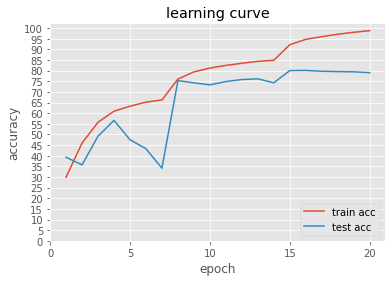

In [ ]:
import time
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt


def load_dataset(batch_size):
    train_set = torchvision.datasets.CIFAR10(
        root="data/cifar-10", train=True,
        download=True, transform=transforms.ToTensor()
    )
    test_set = torchvision.datasets.CIFAR10(
        root="data/cifar-10", train=False,
        download=True, transform=transforms.ToTensor()
    )
    train_iter = torch.utils.data.DataLoader(
        train_set, batch_size=batch_size, shuffle=True, num_workers=4
    )
    test_iter = torch.utils.data.DataLoader(
        test_set, batch_size=batch_size, shuffle=True, num_workers=4
    )
    return train_iter, test_iter


def train(net, train_iter, criterion, optimizer, num_epochs, device, num_print, lr_scheduler=None, test_iter=None):
    net.train()
    record_train = list()
    record_test = list()

    for epoch in range(num_epochs):
        print("========== epoch: [{}/{}] ==========".format(epoch + 1, num_epochs))
        total, correct, train_loss = 0, 0, 0
        start = time.time()

        for i, (X, y) in enumerate(train_iter):
            X, y = X.to(device), y.to(device)
            output = net(X)
            loss = criterion(output, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            total += y.size(0)
            correct += (output.argmax(dim=1) == y).sum().item()
            train_acc = 100.0 * correct / total

            if (i + 1) % num_print == 0:
                print("step: [{}/{}], train_loss: {:.3f} | train_acc: {:6.3f}% | lr: {:.6f}" \
                    .format(i + 1, len(train_iter), train_loss / (i + 1), \
                            train_acc, get_cur_lr(optimizer)))


        if lr_scheduler is not None:
            lr_scheduler.step()

        print("--- cost time: {:.4f}s ---".format(time.time() - start))

        if test_iter is not None:
            record_test.append(test(net, test_iter, criterion, device))
        record_train.append(train_acc)

    return record_train, record_test


def test(net, test_iter, criterion, device):
    total, correct = 0, 0
    net.eval()

    with torch.no_grad():
        print("*************** test ***************")
        for X, y in test_iter:
            X, y = X.to(device), y.to(device)

            output = net(X)
            loss = criterion(output, y)

            total += y.size(0)
            correct += (output.argmax(dim=1) == y).sum().item()

    test_acc = 100.0 * correct / total

    print("test_loss: {:.3f} | test_acc: {:6.3f}%"\
          .format(loss.item(), test_acc))
    print("************************************\n")
    net.train()

    return test_acc


def get_cur_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']


def learning_curve(record_train, record_test=None):
    plt.style.use("ggplot")

    plt.plot(range(1, len(record_train) + 1), record_train, label="train acc")
    if record_test is not None:
        plt.plot(range(1, len(record_test) + 1), record_test, label="test acc")

    plt.legend(loc=4)
    plt.title("learning curve")
    plt.xticks(range(0, len(record_train) + 1, 5))
    plt.yticks(range(0, 101, 5))
    plt.xlabel("epoch")
    plt.ylabel("accuracy")

    plt.show()


import torch.optim as optim


BATCH_SIZE = 128
NUM_EPOCHS = 20
NUM_CLASSES = 10
LEARNING_RATE = 0.4
MOMENTUM = 0.9
WEIGHT_DECAY = 0.0005
NUM_PRINT = 100
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


def main():
    net = Densenet(NUM_CLASSES)
    net = net.to(DEVICE)

    train_iter, test_iter = load_dataset(BATCH_SIZE)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(
        net.parameters(),
        lr=LEARNING_RATE,
        momentum=MOMENTUM,
        weight_decay=WEIGHT_DECAY,
        nesterov=True
    )
    lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    record_train, record_test = train(net, train_iter, criterion, optimizer, \
          NUM_EPOCHS, DEVICE, NUM_PRINT, lr_scheduler, test_iter)

    learning_curve(record_train, record_test)


if __name__ == '__main__':
    main()

#reference:https://blog.csdn.net/cp1314971/article/details/104417808

In [ ]:
DenseNet121 = densenet(in_channel=3, num_classes=NUM_CLASSES, growth_rate=32,block_layers=[6, 12, 24, 16])

DenseNet161 = densenet(in_channel=3, num_classes=NUM_CLASSES, growth_rate=48,block_layers=[6, 12, 36, 24])

DenseNet169 = densenet(in_channel=3, num_classes=NUM_CLASSES, growth_rate=32,block_layers=[6, 12, 32, 32])

DenseNet201 = densenet(in_channel=3, num_classes=NUM_CLASSES, growth_rate=32,block_layers=[6, 12, 48, 32])



## res for DenseNet121 其他的用这个不行， 所以我用DenseNset-bc来实现


Files already downloaded and verified
Files already downloaded and verified
========== epoch: [1/20] ==========
step: [100/196], train_loss: 3.113 | train_acc: 17.223% | lr: 0.500000
--- cost time: 47.8194s ---
*************** test ***************
test_loss: 1.959 | test_acc: 26.810%
************************************

========== epoch: [2/20] ==========
step: [100/196], train_loss: 1.741 | train_acc: 32.746% | lr: 0.500000
--- cost time: 47.6332s ---
*************** test ***************
test_loss: 2.249 | test_acc: 22.540%
************************************

========== epoch: [3/20] ==========
step: [100/196], train_loss: 1.461 | train_acc: 45.461% | lr: 0.500000
--- cost time: 48.1103s ---
*************** test ***************
test_loss: 1.931 | test_acc: 35.150%
************************************

========== epoch: [4/20] ==========
step: [100/196], train_loss: 1.249 | train_acc: 54.172% | lr: 0.500000
--- cost time: 47.9767s ---
*************** test ***************
test_loss: 

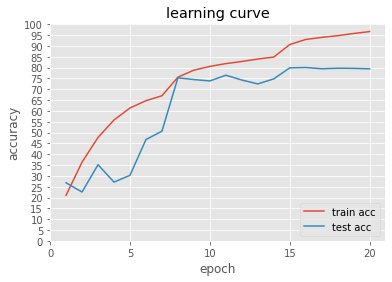

In [ ]:
def main():
    BATCH_SIZE = 256
    net = DenseNet121
    net = net.to(DEVICE)

    train_iter, test_iter = load_dataset(BATCH_SIZE)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(
        net.parameters(),
        lr=LEARNING_RATE,
        momentum=MOMENTUM,
        weight_decay=WEIGHT_DECAY,
        nesterov=True
    )
    lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    record_train, record_test = train(net, train_iter, criterion, optimizer, \
          NUM_EPOCHS, DEVICE, NUM_PRINT, lr_scheduler, test_iter)

    learning_curve(record_train, record_test)


if __name__ == '__main__':
    main()

# DenseNet-BC，耗时巨久，建议别run again

In [ ]:
#DenseNet-BC
import torch
import torchvision
import torchvision.transforms as transforms
 
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
 
trainset = torchvision.datasets.CIFAR10(root='./', train=True,
                                        download=True, transform=transform)
 
testset = torchvision.datasets.CIFAR10(root='./', train=False,
                                       download=False, transform=transform)
 
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100,
                                          shuffle=True, num_workers=2)
 
testloader = torch.utils.data.DataLoader(testset, batch_size=100,
                                         shuffle=False, num_workers=2)
 
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
 
import torch.nn as nn
import torch.nn.functional as F
from collections import OrderedDict
 
class _DenseLayer(nn.Sequential):
    def __init__(self, num_input_features, growth_rate, bn_size, drop_rate):
        super(_DenseLayer, self).__init__()
        self.add_module('norm1', nn.BatchNorm2d(num_input_features)),
        self.add_module('relu1', nn.ReLU(inplace=True)),
        self.add_module('conv1', nn.Conv2d(num_input_features, bn_size *
                        growth_rate, kernel_size=1, stride=1, bias=False)),
        self.add_module('norm2', nn.BatchNorm2d(bn_size * growth_rate)),
        self.add_module('relu2', nn.ReLU(inplace=True)),
        self.add_module('conv2', nn.Conv2d(bn_size * growth_rate, growth_rate,
                        kernel_size=3, stride=1, padding=1, bias=False)),
        self.drop_rate = drop_rate
 
    def forward(self, x):
        new_features = super(_DenseLayer, self).forward(x)
        if self.drop_rate > 0:
            new_features = F.dropout(new_features, p=self.drop_rate, training=self.training)
        return torch.cat([x, new_features], 1)
 
 
class _DenseBlock(nn.Sequential):
    def __init__(self, num_layers, num_input_features, bn_size, growth_rate, drop_rate):
        super(_DenseBlock, self).__init__()
        for i in range(num_layers):
            layer = _DenseLayer(num_input_features + i * growth_rate, growth_rate, bn_size, drop_rate)
            self.add_module('denselayer%d' % (i + 1), layer)
 
 
class _Transition(nn.Sequential):
    def __init__(self, num_input_features, num_output_features):
        super(_Transition, self).__init__()
        self.add_module('norm', nn.BatchNorm2d(num_input_features))
        self.add_module('relu', nn.ReLU(inplace=True))
        self.add_module('conv', nn.Conv2d(num_input_features, num_output_features,
                                          kernel_size=1, stride=1, bias=False))
        self.add_module('pool', nn.AvgPool2d(kernel_size=2, stride=2))
 
 
class DenseNet(nn.Module):
    r"""Densenet-BC model class, based on
    `"Densely Connected Convolutional Networks" <https://arxiv.org/pdf/1608.06993.pdf>`_
    Args:
        growth_rate (int) - how many filters to add each layer (`k` in paper)
        block_config (list of 4 ints) - how many layers in each pooling block
        num_init_features (int) - the number of filters to learn in the first convolution layer
        bn_size (int) - multiplicative factor for number of bottle neck layers
          (i.e. bn_size * k features in the bottleneck layer)
        drop_rate (float) - dropout rate after each dense layer
        num_classes (int) - number of classification classes
    """
 
    def __init__(self, growth_rate=12, block_config=(12, 12, 12),
                 num_init_features=24, bn_size=128, drop_rate=0.2, num_classes=10):
 
        super(DenseNet, self).__init__()
 
        # First convolution
        self.features = nn.Sequential(OrderedDict([
            ('conv0', nn.Conv2d(3, num_init_features, kernel_size=3, stride=1, padding=1, bias=False)),
            ('norm0', nn.BatchNorm2d(num_init_features)),
            ('relu0', nn.ReLU(inplace=True)),
        ]))
 
        # Each denseblock
        num_features = num_init_features
        for i, num_layers in enumerate(block_config):
            block = _DenseBlock(num_layers=num_layers, num_input_features=num_features,
                                bn_size=bn_size, growth_rate=growth_rate, drop_rate=drop_rate)
            self.features.add_module('denseblock%d' % (i + 1), block)
            num_features = num_features + num_layers * growth_rate
            if i != len(block_config) - 1:
                trans = _Transition(num_input_features=num_features, num_output_features=num_features // 2)
                self.features.add_module('transition%d' % (i + 1), trans)
                num_features = num_features // 2
 
        # Final batch norm
        self.features.add_module('norm5', nn.BatchNorm2d(num_features))
 
        # Linear layer
        self.classifier = nn.Linear(num_features, num_classes)
 
        # Official init from torch repo.
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.constant_(m.bias, 0)
 
    def forward(self, x):
        features = self.features(x)
        out = F.relu(features, inplace=True)
        out = F.avg_pool2d(out, kernel_size=8, stride=1).view(features.size(0), -1)
        out = self.classifier(out)
        return out
 
 


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to ./


In [ ]:
net = DenseNet()
 
import torch.optim as optim
 
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)
 
for epoch in range(40):
 
    running_loss = 0.
    batch_size = 100
    
    for i, data in enumerate(
            torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                        shuffle=True, num_workers=2), 0):
        
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        print('[%d, %5d] loss: %.4f' %(epoch + 1, (i+1)*batch_size, loss.item()))
 
print('Finished Training')
 
# torch.save(net, 'DenseNet.pkl')
# net = torch.load('DenseNet.pkl')
 
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
 
print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))
 
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
 
 
for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))


#reference:https://blog.csdn.net/shi2xian2wei2/article/details/84452419

RuntimeError: ignored

## DenseNet161

In [ ]:
net = DenseNet(growth_rate=24, block_config=(12, 36, 24))
 
import torch.optim as optim
 
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)
 
for epoch in range(30):
 
    running_loss = 0.
    batch_size = 100
    
    for i, data in enumerate(
            torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                        shuffle=True, num_workers=2), 0):
        
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        print('[%d, %5d] loss: %.4f' %(epoch + 1, (i+1)*batch_size, loss.item()))
 
print('Finished Training')
 
# torch.save(net, 'DenseNet.pkl')
# net = torch.load('DenseNet.pkl')
 
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
 
print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))
 
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
 
 
for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Streaming output truncated to the last 5000 lines.
[6,  1200] loss: 0.4101
[6,  1300] loss: 0.4359
[6,  1400] loss: 0.3410
[6,  1500] loss: 0.3598
[6,  1600] loss: 0.3750
[6,  1700] loss: 0.2923
[6,  1800] loss: 0.2231
[6,  1900] loss: 0.2366
[6,  2000] loss: 0.3165
[6,  2100] loss: 0.2987
[6,  2200] loss: 0.2754
[6,  2300] loss: 0.3282
[6,  2400] loss: 0.2807
[6,  2500] loss: 0.4201
[6,  2600] loss: 0.2491
[6,  2700] loss: 0.3420
[6,  2800] loss: 0.4091
[6,  2900] loss: 0.4369
[6,  3000] loss: 0.2979
[6,  3100] loss: 0.3206
[6,  3200] loss: 0.3365
[6,  3300] loss: 0.2478
[6,  3400] loss: 0.3637
[6,  3500] loss: 0.3279
[6,  3600] loss: 0.2252
[6,  3700] loss: 0.3561
[6,  3800] loss: 0.2368
[6,  3900] loss: 0.1844
[6,  4000] loss: 0.4317
[6,  4100] loss: 0.4457
[6,  4200] loss: 0.3064
[6,  4300] loss: 0.3539
[6,  4400] loss: 0.3438
[6,  4500] loss: 0.3392
[6,  4600] loss: 0.2572
[6,  4700] loss: 0.3313
[6,  4800] loss: 0.2832
[6,  4900] loss: 0.4707
[6,  5000] loss: 0.2380
[6,  5100] lo

## DenseNet169

In [ ]:
net = DenseNet(growth_rate=24, block_config=(12, 28, 16))
 
import torch.optim as optim
 
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)
 
for epoch in range(10):
 
    running_loss = 0.
    batch_size = 100
    
    for i, data in enumerate(
            torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                        shuffle=True, num_workers=2), 0):
        
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        print('[%d, %5d] loss: %.4f' %(epoch + 1, (i+1)*batch_size, loss.item()))
 
print('Finished Training')
 
# torch.save(net, 'DenseNet.pkl')
# net = torch.load('DenseNet.pkl')
 
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
 
print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))
 
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
 
 
for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

流式输出内容被截断，只能显示最后 5000 行内容。
[1,  1300] loss: 1.9588
[1,  1400] loss: 1.9363
[1,  1500] loss: 1.8821
[1,  1600] loss: 1.8562
[1,  1700] loss: 1.7673
[1,  1800] loss: 1.8480
[1,  1900] loss: 1.8263
[1,  2000] loss: 1.8010
[1,  2100] loss: 1.9571
[1,  2200] loss: 1.8383
[1,  2300] loss: 1.8303
[1,  2400] loss: 1.7878
[1,  2500] loss: 1.7010
[1,  2600] loss: 1.7485
[1,  2700] loss: 1.7271
[1,  2800] loss: 1.6631
[1,  2900] loss: 1.6764
[1,  3000] loss: 1.7195
[1,  3100] loss: 1.7876
[1,  3200] loss: 1.8271
[1,  3300] loss: 1.6114
[1,  3400] loss: 1.7647
[1,  3500] loss: 1.5554
[1,  3600] loss: 1.6798
[1,  3700] loss: 1.6232
[1,  3800] loss: 1.6823
[1,  3900] loss: 1.6296
[1,  4000] loss: 1.5509
[1,  4100] loss: 1.6827
[1,  4200] loss: 1.6595
[1,  4300] loss: 1.6290
[1,  4400] loss: 1.5368
[1,  4500] loss: 1.7180
[1,  4600] loss: 1.7298
[1,  4700] loss: 1.6876
[1,  4800] loss: 1.5118
[1,  4900] loss: 1.4963
[1,  5000] loss: 1.4592
[1,  5100] loss: 1.6669
[1,  5200] loss: 1.8534
[1,  5300] lo

## DenseNet201

In [ ]:
net = DenseNet(growth_rate=48, block_config=(16, 48, 24))
 
import torch.optim as optim
 
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)
 
for epoch in range(35):
 
    running_loss = 0.
    batch_size = 100
    
    for i, data in enumerate(
            torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                        shuffle=True, num_workers=2), 0):
        
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        print('[%d, %5d] loss: %.4f' %(epoch + 1, (i+1)*batch_size, loss.item()))
 
print('Finished Training')
 
# torch.save(net, 'DenseNet.pkl')
# net = torch.load('DenseNet.pkl')
 
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
 
print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))
 
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
 
 
for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

RuntimeError: ignored

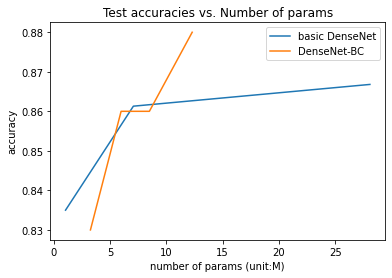

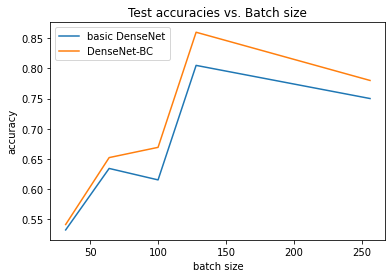

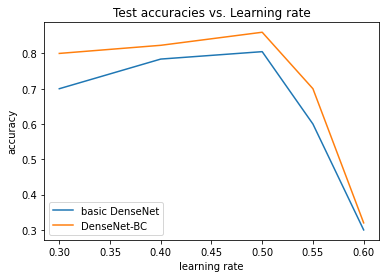

In [ ]:
import matplotlib.pyplot as plt
acc = [0.835, 0.8613, 0.8668]
param = [1.06, 7.08, 28.07]
acc_bc = [0.83, 0.86, 0.86, 0.88]
param_bc = [3.27, 5.99, 8.5, 12.3]


plt.title("Test accuracies vs. Number of params")
plt.plot(param, acc, linestyle = '-', label="basic DenseNet")
plt.plot(param_bc, acc_bc, linestyle = '-', label="DenseNet-BC")
plt.legend()
plt.xlabel('number of params (unit:M)')
plt.ylabel('accuracy')
plt.show()

bs = [32,64,100,128,256]
acc1 = [0.532,0.634,0.615,0.805,0.75]
acc2 = [0.541,0.652,0.669,0.86,0.78]
plt.title("Test accuracies vs. Batch size")
plt.plot(bs, acc1, linestyle = '-', label="basic DenseNet")
plt.plot(bs, acc2, linestyle = '-', label="DenseNet-BC")
plt.legend()
plt.xlabel('batch size')
plt.ylabel('accuracy')
plt.show()

lr = [0.3, 0.4, 0.5, 0.55, 0.6]
acc3 = [0.7,0.784,0.805,0.6, 0.3]
acc4 = [0.8,0.823,0.86,0.7, 0.32]
plt.title("Test accuracies vs. Learning rate")
plt.plot(lr, acc3, linestyle = '-', label="basic DenseNet")
plt.plot(lr, acc4, linestyle = '-', label="DenseNet-BC")
plt.legend()
plt.xlabel('learning rate')
plt.ylabel('accuracy')
plt.show()

# CIFAR-10 dataset

In [ ]:
from matplotlib import pyplot
from keras.datasets import cifar10
(trainX, trainY), (testX, testY) = cifar10.load_data()

170508288/170498071 [==============================] - 4s 0us/step


Train: X=(50000, 32, 32, 3), y=(50000, 1)
Test: X=(10000, 32, 32, 3), y=(10000, 1)


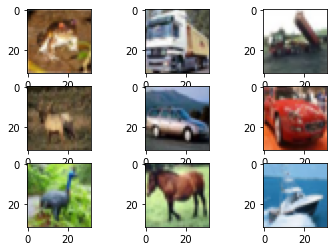

In [ ]:
# summarize loaded dataset
print('Train: X=%s, y=%s' % (trainX.shape, trainY.shape))
print('Test: X=%s, y=%s' % (testX.shape, testY.shape))
# plot first few images
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# plot raw pixel data
	pyplot.imshow(trainX[i])
# show the figure
pyplot.show()

Text(0, 0.5, 'Frequency')

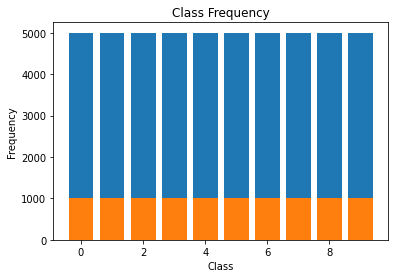

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
unique, counts = np.unique(trainY, return_counts=True)
plt.bar(unique, counts)
unique, counts = np.unique(testY, return_counts=True)
plt.bar(unique, counts)

plt.title('Class Frequency')
plt.xlabel('Class')
plt.ylabel('Frequency')

In [ ]:
!git clone https://github.com/titu1994/DenseNet.git

Cloning into 'DenseNet'...
remote: Enumerating objects: 229, done.
remote: Counting objects: 100% (2/2), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 229 (delta 0), reused 1 (delta 0), pack-reused 227
Receiving objects: 100% (229/229), 20.29 MiB | 31.05 MiB/s, done.
Resolving deltas: 100% (111/111), done.


In [ ]:
!ls


cifar-10-batches-py  cifar-10-python.tar.gz  DenseNet  sample_data


In [ ]:
!ls DenseNet

cifar100.py	  densenet.py		 LICENSE      tensorflow_backend.py
cifar10.py	  imagenet_inference.py  README.md    theano_backend.py
densenet_fast.py  images		 subpixel.py  weights


In [ ]:
!python DenseNet/cifar100.py

Traceback (most recent call last):
  File "DenseNet/cifar100.py", line 6, in <module>
    import densenet
  File "/content/DenseNet/densenet.py", line 19, in <module>
    from keras.layers.normalization import BatchNormalization
ImportError: cannot import name 'BatchNormalization' from 'keras.layers.normalization' (/usr/local/lib/python3.7/dist-packages/keras/layers/normalization/__init__.py)
